/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


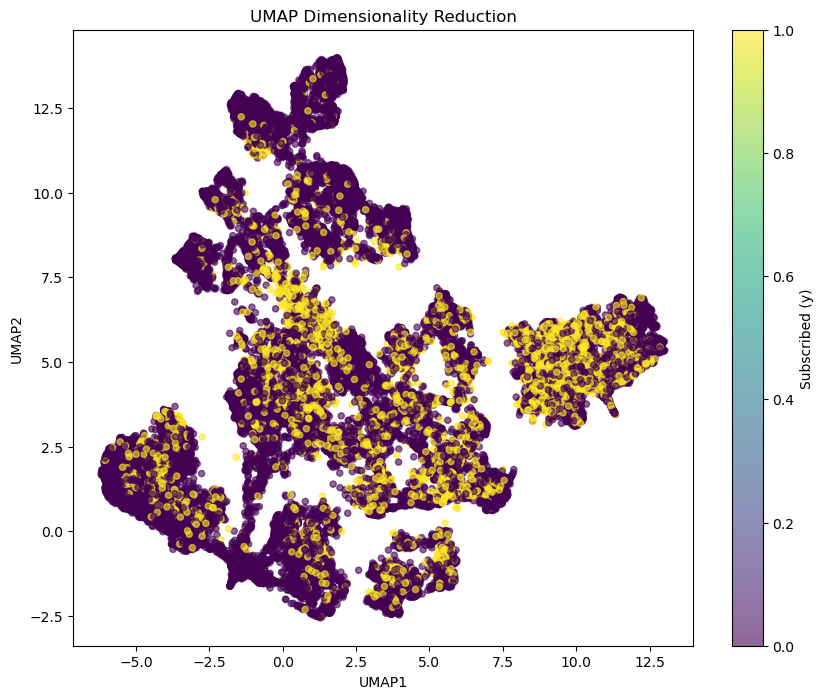

Processed Data Sample with UMAP:
         age           job  marital  education default   balance housing loan  \
0  1.606965    management  married   tertiary      no  0.256419     yes   no   
1  0.288529    technician   single  secondary      no -0.437895     yes   no   
2 -0.747384  entrepreneur  married  secondary      no -0.446762     yes  yes   
3  0.571051   blue-collar  married        NaN      no  0.047205     yes   no   
4 -0.747384           NaN   single        NaN      no -0.447091      no   no   

  contact  day_of_week  ...  duration  campaign     pdays  previous  poutcome  \
0     NaN    -1.298476  ...  0.011016 -0.569351 -0.411453  -0.25194       NaN   
1     NaN    -1.298476  ... -0.416127 -0.569351 -0.411453  -0.25194       NaN   
2     NaN    -1.298476  ... -0.707361 -0.569351 -0.411453  -0.25194       NaN   
3     NaN    -1.298476  ... -0.645231 -0.569351 -0.411453  -0.25194       NaN   
4     NaN    -1.298476  ... -0.233620 -0.569351 -0.411453  -0.25194       NaN   

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import umap
from ucimlrepo import fetch_ucirepo

# 1. 导入数据
bank_marketing = fetch_ucirepo(id=222)
X = bank_marketing.data.features
y = bank_marketing.data.targets['y']

# 将目标变量 y 合并到 X 中，确保可以进行目标编码
X['y'] = y

# 将 'y' 转换为数值型：'yes' -> 1, 'no' -> 0
X['y'] = X['y'].map({'yes': 1, 'no': 0})

# 2. 识别数值特征和类别特征
numerical_cols = ['age', 'balance', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous']
categorical_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month']

# 3. 对数值特征进行标准化
scaler = StandardScaler()
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

# 4. 目标编码：对月份特征进行目标编码（按订阅率计算均值）
month_target_encoding = X.groupby('month')['y'].mean()  # 按月计算订阅率的均值
X['month_encoded'] = X['month'].map(month_target_encoding)  # 将编码值映射到数据中

# 5. 目标编码：对job特征进行目标编码（按订阅率计算均值）
job_target_encoding = X.groupby('job')['y'].mean()  # 按job计算订阅率的均值
X['job_encoded'] = X['job'].map(job_target_encoding)  # 将编码值映射到数据中

# 6. 处理其他类别特征：对其他类别特征进行One-Hot编码
X_processed = pd.get_dummies(X[categorical_cols], drop_first=True)  # One-Hot编码
X_processed[numerical_cols] = X[numerical_cols]  # 将数值特征合并进来

# 7. 使用 UMAP 进行降维
umap_model = umap.UMAP(n_components=2, random_state=42)  # 降到2维
X_umap = umap_model.fit_transform(X_processed)

# 8. 将降维后的数据添加到原始数据中
X_raw = X.copy()
X_raw['UMAP1'] = X_umap[:, 0]
X_raw['UMAP2'] = X_umap[:, 1]

# 9. 可视化降维结果
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.scatter(X_raw['UMAP1'], X_raw['UMAP2'], c=X_raw['y'], cmap='viridis', s=20, alpha=0.6)
plt.title('UMAP Dimensionality Reduction')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.colorbar(label='Subscribed (y)')
plt.show()

# 10. 保存降维后的数据
X_raw.to_csv('umap_reduced_data.csv', index=False)

# 11. 查看处理后的数据（带有UMAP降维后的特征）
print("Processed Data Sample with UMAP:\n", X_raw.head())


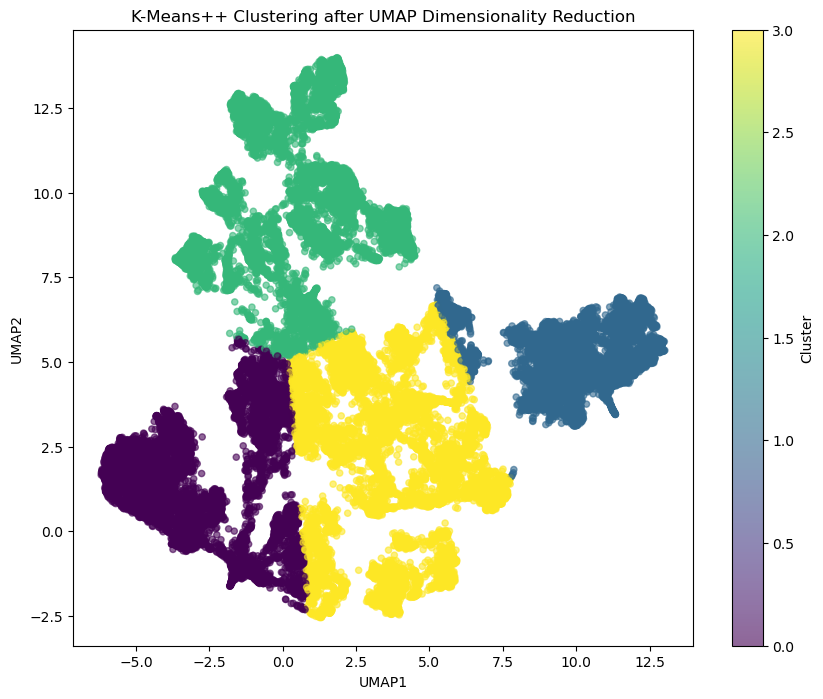

In [5]:
from sklearn.cluster import KMeans

# 使用 K-Means++
kmeans_plus = KMeans(n_clusters=4, init='k-means++', random_state=42)
clusters_kmeans = kmeans_plus.fit_predict(X_umap)  # 使用降维后的数据

# 可视化聚类结果
plt.figure(figsize=(10, 8))
plt.scatter(X_raw['UMAP1'], X_raw['UMAP2'], c=clusters_kmeans, cmap='viridis', s=20, alpha=0.6)
plt.title('K-Means++ Clustering after UMAP Dimensionality Reduction')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.colorbar(label='Cluster')
plt.show()


In [6]:
# 1. 将聚类结果保存到原始数据中
X_raw['Cluster'] = clusters_kmeans

# 2. 聚类分析：查看每个簇的订阅率（y）的均值
cluster_summary = X_raw.groupby('Cluster').agg({
    'y': 'mean',  # 计算每个簇的订阅率均值
    **{col: 'mean' for col in numerical_cols}  # 计算每个簇的数值型特征均值
})
print("Cluster Summary (Numerical Features):\n", cluster_summary)

# 3. 聚类分析：查看每个簇的类别特征的众数
cluster_mode = X_raw.groupby('Cluster').agg({
    **{col: lambda x: x.mode()[0] for col in categorical_cols}  # 计算每个簇的类别特征的众数
})
print("Cluster Mode (Categorical Features):\n", cluster_mode)

# 4. 高订阅率群体分析：分析订阅率较高的群体
high_subscription_cluster = cluster_summary[cluster_summary['y'] > 0.5]
print("High Subscription Clusters:\n", high_subscription_cluster)

# 5. 保存聚类结果到 CSV 文件
X_raw.to_csv('kmeans_plus_clustered_data.csv', index=False)


Cluster Summary (Numerical Features):
                 y       age   balance  day_of_week  duration  campaign  \
Cluster                                                                  
0        0.057032  0.022486 -0.183227     0.155778 -0.156756  0.509386   
1        0.208994 -0.034274 -0.003768    -0.299968 -0.023452 -0.214194   
2        0.094743 -0.136142 -0.150136     0.015360  0.309931 -0.151206   
3        0.125199  0.111359  0.258326     0.048222 -0.114706 -0.134754   

            pdays  previous  
Cluster                      
0       -0.406838 -0.248524  
1        1.717954  1.039259  
2       -0.403832 -0.245193  
3       -0.388676 -0.232610  
Cluster Mode (Categorical Features):
                  job  marital  education default housing loan   contact month
Cluster                                                                      
0        blue-collar  married  secondary      no      no   no  cellular   jul
1         management  married  secondary      no     yes   no  c

Silhouette Score for K-Means++: 0.4652
Davies-Bouldin Score for K-Means++: 0.7609
Calinski-Harabasz Score for K-Means++: 57124.0396


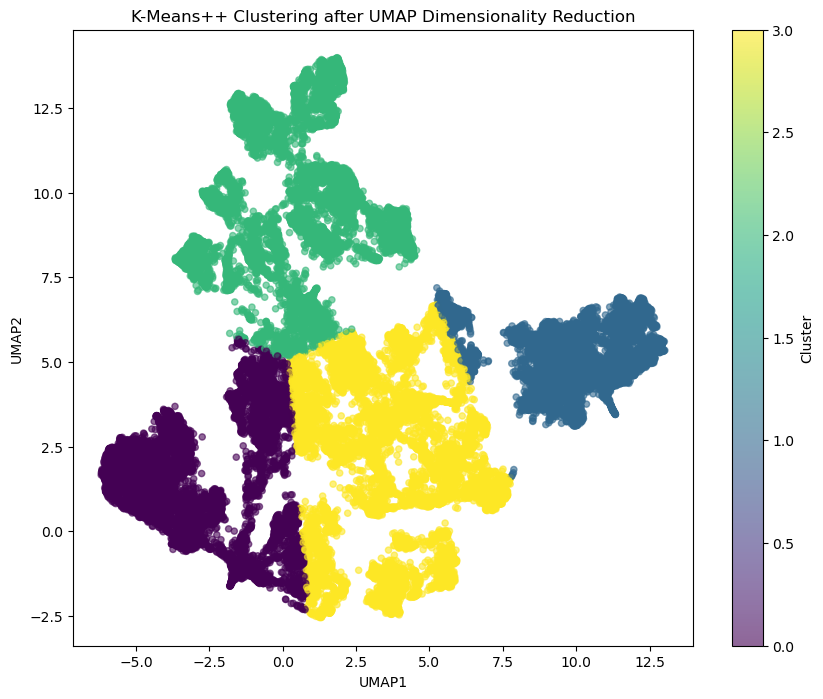

Silhouette Score for Stable K-Means++: 0.4668


In [7]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# 计算轮廓系数（Silhouette Score）
silhouette_avg = silhouette_score(X_umap, clusters_kmeans)
print(f"Silhouette Score for K-Means++: {silhouette_avg:.4f}")

# 计算 Davies-Bouldin指数
db_score = davies_bouldin_score(X_umap, clusters_kmeans)
print(f"Davies-Bouldin Score for K-Means++: {db_score:.4f}")

# 计算 Calinski-Harabasz指数
ch_score = calinski_harabasz_score(X_umap, clusters_kmeans)
print(f"Calinski-Harabasz Score for K-Means++: {ch_score:.4f}")

# 可视化评估：查看 K-Means++ 聚类结果
plt.figure(figsize=(10, 8))
plt.scatter(X_raw['UMAP1'], X_raw['UMAP2'], c=clusters_kmeans, cmap='viridis', s=20, alpha=0.6)
plt.title('K-Means++ Clustering after UMAP Dimensionality Reduction')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.colorbar(label='Cluster')
plt.show()

# 运行 K-Means++ 聚类多次并比较稳定性
kmeans_stable = KMeans(n_clusters=4, init='k-means++', n_init=10, random_state=42)
clusters_stable = kmeans_stable.fit_predict(X_umap)

# 计算轮廓系数来比较稳定性
silhouette_stable = silhouette_score(X_umap, clusters_stable)
print(f"Silhouette Score for Stable K-Means++: {silhouette_stable:.4f}")
